# FI-2Pop demo

Demo notebook on the integration of FI-2Pop with the L-System.

## Imports

In [1]:
import json

GECCO-compatible `matplotlib` options:

In [2]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Import `PCGSEPy` modules:

In [3]:
from pcgsepy.common.vecs import orientation_from_str, Vec 
from pcgsepy.config import COMMON_ATOMS, HL_ATOMS, N_ITERATIONS, REQ_TILES 
from pcgsepy.lsystem.rules import RuleMaker
from pcgsepy.lsystem.actions import AtomAction, Rotations
from pcgsepy.lsystem.parser import HLParser, LLParser
from pcgsepy.lsystem.solver import LSolver
from pcgsepy.lsystem.constraints import ConstraintHandler, ConstraintLevel, ConstraintTime
from pcgsepy.lsystem.constraints_funcs import components_constraint, intersection_constraint, symmetry_constraint, wheels_plane_constraint
from pcgsepy.lsystem.lsystem import LSystem
from pcgsepy.structure import block_definitions

## Setup

In [4]:
# import logging

# logging.basicConfig()
# logger = logging.getLogger('base-logger')
# logger.setLevel(logging.WARNING)

In [5]:
with open(COMMON_ATOMS, "r") as f:
    common_alphabet = json.load(f)

for k in common_alphabet:
    action, args = common_alphabet[k]["action"], common_alphabet[k]["args"]
    action = AtomAction(action)
    if action == AtomAction.MOVE:
        args = orientation_from_str[args]
    elif action == AtomAction.ROTATE:
        args = Rotations(args)
    common_alphabet[k] = {"action": action, "args": args}

In [6]:
with open(HL_ATOMS, "r") as f:
    hl_atoms = json.load(f)

tiles_dimensions = {}
tiles_block_offset = {}
for tile in hl_atoms.keys():
    dx, dy, dz = hl_atoms[tile]["dimensions"]
    tiles_dimensions[tile] = Vec.v3i(dx, dy, dz)
    tiles_block_offset[tile] = hl_atoms[tile]["offset"]

hl_alphabet = {}
for k in common_alphabet.keys():
    hl_alphabet[k] = common_alphabet[k]

for hk in hl_atoms.keys():
    hl_alphabet[hk] = {"action": AtomAction.PLACE, "args": []}

In [7]:
ll_alphabet = {}

for k in common_alphabet.keys():
    ll_alphabet[k] = common_alphabet[k]

for k in block_definitions.keys():
    if k != "":  # TODO: This is a probable bug, reported to the SE API devs
        ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

## L-System components

In [8]:
hl_rules = RuleMaker(ruleset='hlrules').get_rules()
ll_rules = RuleMaker(ruleset='llrules').get_rules()

hl_parser = HLParser(rules=hl_rules)
ll_parser = LLParser(rules=ll_rules)

hl_solver = LSolver(parser=hl_parser,
                    atoms_alphabet=hl_alphabet,
                    extra_args={
                        'tiles_dimensions': tiles_dimensions,
                        'tiles_block_offset': tiles_block_offset,
                        'll_rules': ll_rules
                    })
ll_solver = LSolver(parser=ll_parser,
                    atoms_alphabet=dict(hl_alphabet, **ll_alphabet),
                    extra_args={})

In [9]:
rcc1 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc1.extra_args["req_tiles"] = ['cockpit']

rcc2 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc2.extra_args["req_tiles"] = ['corridorcargo', 'corridorgyros', 'corridorreactors']

rcc3 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc3.extra_args["req_tiles"] = ['thrusters']

nic = ConstraintHandler(
    name="no_intersections",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.DURING,
    f=intersection_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    },
    needs_ll=True
)
nic.extra_args["tiles_dimensions"] = tiles_dimensions

sc = ConstraintHandler(
    name="symmetry",
    level=ConstraintLevel.SOFT_CONSTRAINT,
    when=ConstraintTime.END,
    f=symmetry_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    }
)

In [10]:
lsystem = LSystem(
    hl_solver=hl_solver, ll_solver=ll_solver, names=['HeadModule', 'BodyModule', 'TailModule']
)

In [11]:
lsystem.add_hl_constraints(cs=[
    [nic, rcc1],
    [nic, rcc2],
    [nic, rcc3]
])

lsystem.add_ll_constraints(cs=[
    [sc],
    [sc],
    [sc]
])

## FI-2Pop

In [12]:
from pcgsepy.config import POP_SIZE, N_RETRIES, USE_BBOX, BBOX_X, BBOX_Y, BBOX_Z, N_GENS

In [13]:
# def compute_fitness(axiom: str) -> float:
#     # return float(len(axiom))
#     return 500 - abs(500 - float(len(axiom)))

from typing import Any, Dict
from pcgsepy.common.vecs import Orientation, Vec
from pcgsepy.lsystem.structure_maker import LLStructureMaker
from pcgsepy.structure import Structure
# np.nonzero(structure)
def compute_fitness_old(axiom: str, extra_args: Dict[str, Any]) -> float:
    if not USE_BBOX:
        return 0.
    else:
        base_position, orientation_forward, orientation_up = Vec.v3i(
            0, 0, 0), Orientation.FORWARD.value, Orientation.UP.value
        structure = Structure(origin=base_position,
                              orientation_forward=orientation_forward,
                              orientation_up=orientation_up)
        structure = LLStructureMaker(atoms_alphabet=extra_args['alphabet'],
                                     position=base_position).fill_structure(
                                         structure=structure,
                                         axiom=axiom,
                                         additional_args={})
        structure.update(origin=base_position,
                         orientation_forward=orientation_forward,
                         orientation_up=orientation_up)

        x, y, z = structure._max_dims
        f = BBOX_X - abs(BBOX_X - x)
        f += BBOX_Y - abs(BBOX_Y - y)
        f += BBOX_Z - abs(BBOX_Z - z)
        return f

import numpy as np

def compute_fitness(axiom: str, extra_args: Dict[str, Any]) -> float:
    if not USE_BBOX:
        return 0.
    else:
        base_position, orientation_forward, orientation_up = Vec.v3i(
            0, 0, 0), Orientation.FORWARD.value, Orientation.UP.value
        structure = Structure(origin=base_position,
                              orientation_forward=orientation_forward,
                              orientation_up=orientation_up)
        structure = LLStructureMaker(atoms_alphabet=extra_args['alphabet'],
                                     position=base_position).fill_structure(
                                         structure=structure,
                                         axiom=axiom,
                                         additional_args={})
        structure.update(origin=base_position,
                         orientation_forward=orientation_forward,
                         orientation_up=orientation_up)

        # x, y, z = structure._max_dims
        # f = BBOX_X - abs(BBOX_X - x)
        # f += BBOX_Y - abs(BBOX_Y - y)
        # f += BBOX_Z - abs(BBOX_Z - z)

        # filled boxed volume as percentage
        ps, _, _ = np.nonzero(structure.as_array()[:int(BBOX_X), :int(BBOX_Y), :int(BBOX_Z)])
        actual_v = len(ps)
        ideal_v = BBOX_X * BBOX_Y * BBOX_Z
        filled_v = actual_v / ideal_v
        f = 1 - abs(1 - filled_v)
        
        return 100*f

In [14]:
from typing import Any, Dict, List, Tuple

from pcgsepy.lsystem.lsystem import LSystem


def subdivide_axioms(hl_axioms: List[str],
                     lsystem: LSystem) -> Dict[str, Any]:
    lsystem.hl_solver.set_constraints(cs=lsystem.all_hl_constraints)
    lsystem.ll_solver.set_constraints(cs=lsystem.all_ll_constraints)
    axioms_sats = {}
    for hl_axiom in hl_axioms:
        axioms_sats[hl_axiom] = {
            'feasible': True,
            'n_constraints_v': 0
        }
        for t in [ConstraintTime.DURING, ConstraintTime.END]:
            sat = lsystem.hl_solver._check_constraints(axiom=hl_axiom,
                                                       when=t,
                                                       keep_track=True)
            axioms_sats[hl_axiom]['feasible'] &= sat[ConstraintLevel.HARD_CONSTRAINT][0]
            axioms_sats[hl_axiom]['n_constraints_v'] += sat[ConstraintLevel.HARD_CONSTRAINT][1]
            axioms_sats[hl_axiom]['n_constraints_v'] += sat[ConstraintLevel.SOFT_CONSTRAINT][1]

    to_expand_further = []
    for hl_axiom in axioms_sats.keys():
        if axioms_sats[hl_axiom]['feasible']:
            to_expand_further.append(hl_axiom)

    ml_axioms = [lsystem.hl_solver.translator.transform(axiom=hl_axiom) for hl_axiom in to_expand_further]
    # ml_axioms = lsystem.get_ml_axioms(hl_axioms=to_expand_further)
    for i, ml_axiom in enumerate(ml_axioms):
        for t in [ConstraintTime.DURING, ConstraintTime.END]:
            ll_axiom = LLParser(rules=lsystem.hl_solver.ll_rules).expand(axiom=ml_axiom)
            sat = lsystem.ll_solver._check_constraints(axiom=ll_axiom,
                                                       when=t,
                                                       keep_track=True)
            axioms_sats[to_expand_further[i]]['feasible'] &= sat[ConstraintLevel.HARD_CONSTRAINT][0]
            axioms_sats[to_expand_further[i]]['n_constraints_v'] += sat[ConstraintLevel.HARD_CONSTRAINT][1]
            axioms_sats[to_expand_further[i]]['n_constraints_v'] += sat[ConstraintLevel.SOFT_CONSTRAINT][1]

    return axioms_sats


def generate_initial_populations(lsystem: LSystem,
                                 pops_size: int = POP_SIZE,
                                 n_retries: int = N_RETRIES) -> Tuple[List[str], List[str], List[float]]:
    feasible_pop, infeasible_pop = [], []
    f_fitnesses, i_fitnesses = [], []
    i = 0
    lsystem.disable_sat_check()
    while len(feasible_pop) < pops_size or len(infeasible_pop) < pops_size:
        
        print(f'Attempt {i+1}/{n_retries}; fpop: {len(feasible_pop)}; ipop: {len(infeasible_pop)}')
        
        _, hl_axioms, _ = lsystem.apply_rules(starting_axioms=[
                                                  'head',
                                                  'body',
                                                  'tail'
                                                  ],
                                              iterations=[
                                                  1,
                                                  N_ITERATIONS,
                                                  1
                                                  ],
                                              create_structures=False,
                                              make_graph=False)
        axioms_sats = subdivide_axioms(hl_axioms=hl_axioms,
                                       lsystem=lsystem)
        
        n_symmetric = 0
        
        for axiom in axioms_sats.keys():
            if axioms_sats[axiom]['feasible'] and len(feasible_pop) < pops_size and axiom not in feasible_pop:
                feasible_pop.append(axiom)
                f_fitnesses.append(
                    compute_fitness(axiom=lsystem.ll_solver.solve(axiom=lsystem.hl_solver.translator.transform(axiom=axiom),
                                                                  iterations=1,
                                                                  check_sat=False)[0],
                                                                  # get_ll_axioms(lsystem.get_ml_axioms(hl_axioms=[axiom]))[0][0],
                                    extra_args={
                                        'alphabet': lsystem.ll_solver.atoms_alphabet
                                    })
                    - axioms_sats[axiom]['n_constraints_v']
                )
                
                n_symmetric += 1 if axioms_sats[axiom]['n_constraints_v'] == 0 else 0
                
            elif not axioms_sats[axiom]['feasible'] and len(infeasible_pop) < pops_size and axiom not in feasible_pop:
                infeasible_pop.append(axiom)
                i_fitnesses.append(axioms_sats[axiom]['n_constraints_v'])
        i += 1
        if i == n_retries:
            break
            
    symmetry_tracker.append(n_symmetric)
            
    return feasible_pop, infeasible_pop, f_fitnesses, i_fitnesses

In [15]:
from random import random
from typing import List


def roulette_wheel_selection(axioms: List[str],
                             fitnesses: List[float],
                             minimize: bool = False) -> str:
    if not minimize:
        fs = fitnesses
    else:
        fs = [1 / f for f in fitnesses]
    s = sum(fs)
    r = s * random()
    p = 0.
    for i, f in enumerate(fs):
        p += f
        if p >= r:
            return axioms[i]
    raise Exception('Unable to find axiom')

In [16]:
from pcgsepy.lsystem.parser import HLtoMLTranslator

translator = HLtoMLTranslator(alphabet=hl_alphabet,
                              tiles_dims=tiles_dimensions,
                              tiles_block_offset={})

In [17]:
from pcgsepy.evo.genops import crossover, mutate


def create_new_pool(population: List[str],
                    fitnesses: List[float],
                    generation: int,
                    translator: HLtoMLTranslator,
                    n_individuals: int = POP_SIZE,
                    minimize: bool = False) -> List[str]:
    pool = []

    while len(pool) < n_individuals:
        # fitness-proportionate selection
        p1 = roulette_wheel_selection(axioms=population, fitnesses=fitnesses, minimize=minimize)
        p2 = roulette_wheel_selection(axioms=population, fitnesses=fitnesses, minimize=minimize)
        # crossover
        o1, o2 = crossover(a1=p1, a2=p2, n_childs=2, translator=translator)
        # mutation
        o1 = mutate(axiom=o1, translator=translator, n_iteration=generation)
        o2 = mutate(axiom=o2, translator=translator, n_iteration=generation)

        for o in [o1, o2]:
            if o not in pool:
                pool.append(o)

    return pool

In [18]:
def reduce_population(population: List[str],
                      fitnesses: List[str],
                      to: int) -> Tuple[List[str], List[str]]:
    f_ordered_idxs = [i for _, i in sorted(zip(fitnesses, range(len(fitnesses))))][-to:]
    red_pop, red_f = [], []
    for i in f_ordered_idxs:
        red_pop.append(population[i])
        red_f.append(fitnesses[i])
    return red_pop, red_f

In [19]:
highest_if = []
mean_if = []

In [20]:
from tqdm.notebook import tqdm, trange


def if2pop(f_pop: List[str],
           i_pop: List[str],
           f_fitnesses: List[float],
           i_fitnesses: List[float],
           n_iter: int) -> Tuple[List[str], List[str]]:    
    f_pool = []
    i_pool = []
    
    f_pool_fitnesses = []
    i_pool_fitnesses = []
    # for gen in range(n_iter):
    with trange(n_iter, desc='Generation ') as gens:
        for gen in gens:

            n_symmetric = 0

            # create offsprings from feasible population
            new_pool = create_new_pool(population=f_pop,
                                       fitnesses=f_fitnesses,
                                       generation=gen,
                                       translator=lsystem.hl_solver.translator)
            # if feasible, add to feasible pool
            # if infeasible, add to infeasible pool
            axioms_sats = subdivide_axioms(hl_axioms=new_pool,
                                           lsystem=lsystem)
            for axiom in axioms_sats.keys():
                if axioms_sats[axiom]['feasible']:
                    f_pool.append(axiom)
                    f_pool_fitnesses.append(compute_fitness(axiom=lsystem.ll_solver.solve(axiom=lsystem.hl_solver.translator.transform(axiom=axiom),
                                                                                          iterations=1,
                                                                                          check_sat=False)[0],
                                                            extra_args={
                                                                'alphabet': lsystem.ll_solver.atoms_alphabet
                                                                })
                                            - axioms_sats[axiom]['n_constraints_v'])

                    n_symmetric += 1 if axioms_sats[axiom]['n_constraints_v'] == 0 else 0

                else:
                    i_pool.append(axiom)
                    i_pool_fitnesses.append(axioms_sats[axiom]['n_constraints_v'])
            # place the infeasible population in the infeasible pool
            i_pool.extend(i_pop)
            i_pool_fitnesses.extend(i_fitnesses)
            # reduce the infeasible pool if > pops_size
            if len(i_pool) > POP_SIZE:
                i_pool, i_pool_fitnesses = reduce_population(population=i_pool,
                                                             fitnesses=i_pool_fitnesses,
                                                             to=POP_SIZE)
            # set the infeasible pool as the infeasible population
            i_pop[:] = i_pool[:]
            i_fitnesses[:] = i_pool_fitnesses[:]
            # create offsprings from infeasible population
            new_pool = create_new_pool(population=i_pop,
                                       fitnesses=i_fitnesses,
                                       generation=gen,
                                       translator=lsystem.hl_solver.translator,
                                       minimize=True)
            # if feasible, add to feasible pool
            # if infeasible, add to infeasible pool
            axioms_sats = subdivide_axioms(hl_axioms=new_pool,
                                           lsystem=lsystem)
            for axiom in axioms_sats.keys():
                if axioms_sats[axiom]['feasible']:
                    f_pool.append(axiom)
                    f_pool_fitnesses.append(compute_fitness(axiom=lsystem.ll_solver.solve(axiom=lsystem.hl_solver.translator.transform(axiom=axiom),
                                                                                          iterations=1,
                                                                                          check_sat=False)[0],
                                                            extra_args={
                                                                'alphabet': lsystem.ll_solver.atoms_alphabet
                                                                })
                                            - axioms_sats[axiom]['n_constraints_v'])

                    n_symmetric += 1 if axioms_sats[axiom]['n_constraints_v'] == 0 else 0

                else:
                    i_pool.append(axiom)
                    i_pool_fitnesses.append(axioms_sats[axiom]['n_constraints_v'])
            # reduce the feasible pool if > pops_size
            if len(f_pool) > POP_SIZE:
                f_pool, f_pool_fitnesses = reduce_population(population=f_pool,
                                                             fitnesses=f_pool_fitnesses,
                                                             to=POP_SIZE)
            # set the feasible pool as the feasible population
            f_pop[:] = f_pool[:]
            f_fitnesses[:] = f_pool_fitnesses[:]

            symmetry_tracker.append(n_symmetric)


            highest_if.append(max(f_fitnesses))
            mean_if.append(sum(f_fitnesses) / len(f_fitnesses))
            
            gens.set_postfix(ordered_dict={'top-f': highest_if[-1],
                                           'mean-f': mean_if[-1]},
                             refresh=True)

    return f_pop, i_pop

In [21]:
symmetry_tracker = []

f_pop, i_pop, f_fitnesses, i_fitnesses = generate_initial_populations(lsystem=lsystem)

print(len(f_pop), len(i_pop))

highest_if.append(max(f_fitnesses))
mean_if.append(sum(f_fitnesses) / len(f_fitnesses))

Attempt 1/100; fpop: 0; ipop: 0
Attempt 2/100; fpop: 4; ipop: 20
Attempt 3/100; fpop: 6; ipop: 20
Attempt 4/100; fpop: 10; ipop: 20
Attempt 5/100; fpop: 13; ipop: 20
Attempt 6/100; fpop: 19; ipop: 20
20 20


In [22]:
f_fitnesses

[1.2645166666666712,
 0.6944333333333335,
 0.1960666666666615,
 2.7013999999999987,
 2.595116666666664,
 2.717866666666669,
 1.771433333333328,
 2.944400000000003,
 1.9310500000000013,
 1.141266666666663,
 1.7943666666666696,
 2.57655,
 0.9388833333333295,
 2.49706666666667,
 0.19029999999999925,
 3.092733333333331,
 1.329516666666664,
 2.4053833333333334,
 -0.44986666666666464,
 1.3042499999999961]

In [23]:
_, _ = if2pop(f_pop=f_pop,
              i_pop=i_pop,
              f_fitnesses=f_fitnesses,
              i_fitnesses=i_fitnesses,
              n_iter=N_GENS)

Generation :   0%|          | 0/20 [00:00<?, ?it/s]

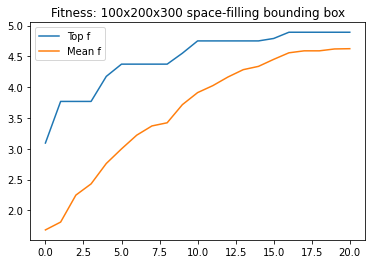

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(len(highest_if)), highest_if, label='Top f')
plt.plot(range(len(mean_if)), mean_if, label='Mean f')

plt.legend()
plt.title('Fitness: 100x200x300 space-filling bounding box')

plt.show()

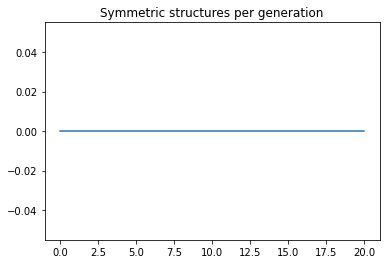

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(len(symmetry_tracker)), symmetry_tracker)

# plt.legend()
plt.title('Symmetric structures per generation')

plt.show()

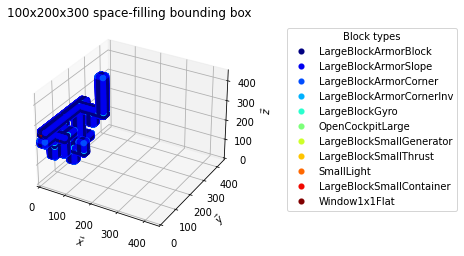

In [26]:
from pcgsepy.lsystem.structure_maker import LLStructureMaker
from pcgsepy.common.vecs import Orientation
from pcgsepy.structure import Structure

hl_axiom = f_pop[f_fitnesses.index(max(f_fitnesses))]
ml_axiom = lsystem.hl_solver.translator.transform(axiom=hl_axiom)
ll_axiom = lsystem.ll_solver.solve(axiom=ml_axiom,
                                  iterations=1,
                                  axioms_per_iteration=1,
                                  check_sat=False)[0]

base_position, orientation_forward, orientation_up = Vec.v3i(
            0, 0, 0), Orientation.FORWARD.value, Orientation.UP.value
structure = Structure(origin=base_position,
                      orientation_forward=orientation_forward,
                      orientation_up=orientation_up)
structure = LLStructureMaker(
    atoms_alphabet=lsystem.ll_solver.atoms_alphabet,
    position=base_position).fill_structure(structure=structure,
                                           axiom=ll_axiom)
structure.sanify()
structure.show(title='100x200x300 space-filling bounding box')

In [27]:
print(f'HL AXIOM:\n\t{hl_axiom}\n---\nML AXIOM:\n\t{ml_axiom}\n---\nLL AXIOM:\n\t{ll_axiom}')

HL AXIOM:
	cockpit(1)corridorsimple(1)corridorsimple(5)[RotYcwZcorridorsimple(3)corridorsimple(1)[RotYcwZcorridorsimple(1)corridorsimple(1)[RotYccwZcorridorsimple(1)corridorreactors(2)][RotYcwZcorridorsimple(1)[RotYccwZcorridorsimple(3)][RotYccwXcorridorsimple(1)[RotYcwZcorridorsimple(2)]]]]corridorsimple(1)corridorgyros(3)corridorcargo(1)]corridorsimple(3)corridorreactors(2)[RotYcwZcorridorsimple(5)corridorsimple(6)[RotYccwZcorridorsimple(1)corridorreactors(2)][RotYcwZcorridorsimple(1)[RotYccwZcorridorsimple(3)][RotYccwXcorridorsimple(1)[RotYcwZcorridorsimple(2)]]]][RotYccwXcorridorsimple(2)[RotYcwZcorridorsimple(3)]corridorcargo(1)[RotYccwZcorridorsimple(1)corridorcargo(4)corridorsimple(2)corridorgyros(2)corridorcargo(2)]]thrusters(2)
---
ML AXIOM:
	cockpit!(15)corridorsimple!(15)corridorsimple!(15)corridorsimple!(15)corridorsimple!(15)corridorsimple!(15)corridorsimple!(15)[>(5)RotYcwZcorridorsimple!(15)corridorsimple!(15)corridorsimple!(15)corridorsimple!(15)[>(5)RotYcwZcorridorsimp

In [28]:
do_place_blocks = False

In [29]:
if do_place_blocks:
    from pcgsepy.common.api_call import GameMode, get_base_values, toggle_gamemode
    from pcgsepy.structure import place_blocks
    
    base_position, orientation_forward, orientation_up = get_base_values()
    structure.update(
        origin=base_position,
        orientation_forward=orientation_forward,
        orientation_up=orientation_up,
    )
    toggle_gamemode(GameMode.PLACING)
    place_blocks(structure.get_all_blocks(), False)
    toggle_gamemode(GameMode.EVALUATING)